In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
path = '/content/drive/MyDrive/FakeNewsNet/final.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,title,label
0,Jax Taylor recalls his 'near-death' experience...,true
1,Bobbi Kristina Brown,true
2,'Shahs of Sunset' Star Mercedes 'MJ' Javid Is ...,true
3,Kourtney Kardashian Needs Scott Disick to Be '...,true
4,Celine Dion Sings Rihanna Song When Asked Abou...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['label']
labels_encoded = label_encoder.fit_transform(label)
df['label'] = labels_encoded
df.head()

,title,label
0,Jax Taylor recalls his 'near-death' experience...,1
1,Bobbi Kristina Brown,1
2,'Shahs of Sunset' Star Mercedes 'MJ' Javid Is ...,1
3,Kourtney Kardashian Needs Scott Disick to Be '...,1
4,Celine Dion Sings Rihanna Song When Asked Abou...,1


In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df, df['label'] = ros.fit_resample(df, df['label'])

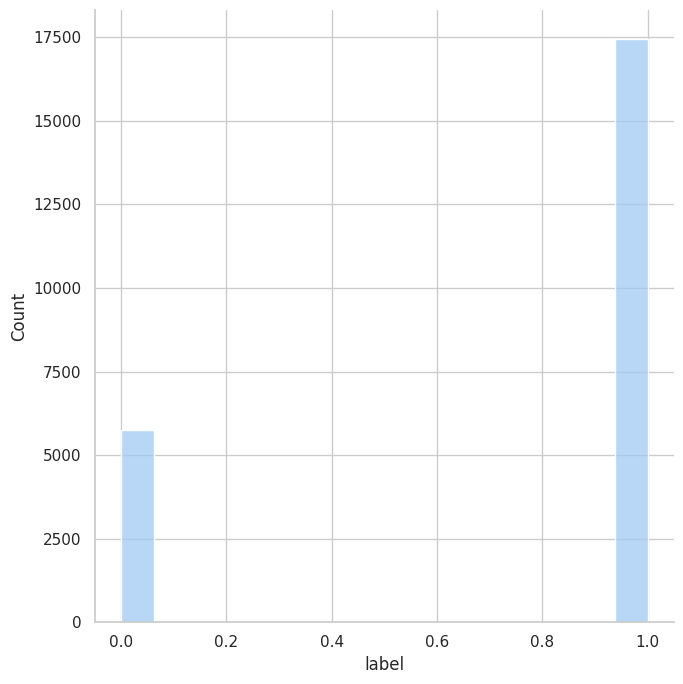

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="label",height=7,aspect=1)

## **DistilBERT - Train**

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers[:-2]:
    layer.trainable = False


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(df['title'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, df['label'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['title'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['title'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 2
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/2
9278/9278 [==============================] - 196s 20ms/step - loss: 0.5127 - accuracy: 0.7549
Epoch 2/2
9278/9278 [==============================] - 190s 21ms/step - loss: 0.5036 - accuracy: 0.7577


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

2320/2320 [==============================] - 47s 19ms/step - loss: 0.5011 - accuracy: 0.7502


In [ ]:
print(benchmarks)

{'loss': 0.5011154413223267, 'accuracy': 0.7502155303955078}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 1,538
Non-trainable params: 66,953,472
_________________________________________________________________


## **DistilBERT embeddings**

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

#### FakeNewsNet Title Embeddings DistilBERT

In [ ]:
#το συγκεκριμένο τμήμα είναι χρονοβόρο οπότε καλό θα ήταν να χρησιμοποιούνται τα αποθηκευμένα αρχεία που έχουμε δημιουργήσει (embeddings.npy,labels.npy)
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['title'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsNet/embeddings_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsNet/labels_title_distilbert.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/FakeNewsNet/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/FakeNewsNet/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([18556, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
1160/1160 [==============================] - 9s 6ms/step - loss: 0.5177 - accuracy: 0.7602 - val_loss: 0.4657 - val_accuracy: 0.7970
Epoch 2/10
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4552 - accuracy: 0.7854 - val_loss: 0.4403 - val_accuracy: 0.8108
Epoch 3/10
1160/1160 [==============================] - 6s 5ms/step - loss: 0.4327 - accuracy: 0.8127 - val_loss: 0.4490 - val_accuracy: 0.8065
Epoch 4/10
1160/1160 [==============================] - 7s 6ms/step - loss: 0.4197 - accuracy: 0.8198 - val_loss: 0.4324 - val_accuracy: 0.8177
Epoch 5/10
1160/1160 [==============================] - 6s 5ms/step - loss: 0.4066 - accuracy: 0.8249 - val_loss: 0.4317 - val_accuracy: 0.8153
Epoch 6/10
1160/1160 [==============================] - 7s 6ms/step - loss: 0.3946 - accuracy: 0.8279 - val_loss: 0.4281 - val_accuracy: 0.8175
Epoch 7/10
1160/1160 [==============================] - 6s 5ms/step - loss: 0.3852 - accuracy: 0.8347 - val_loss: 0.4310 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

145/145 [==============================] - 0s 2ms/step
Test Accuracy: 0.8221982717514038
Test F1 Score: 0.8874641931523667
Test Recall: 0.9312911537360435
Precision: 0.8475768629494529


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_3 (Flatten)         (None, 3200)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

145/145 [==============================] - 0s 2ms/step
[[ 562  585]
 [ 240 3253]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

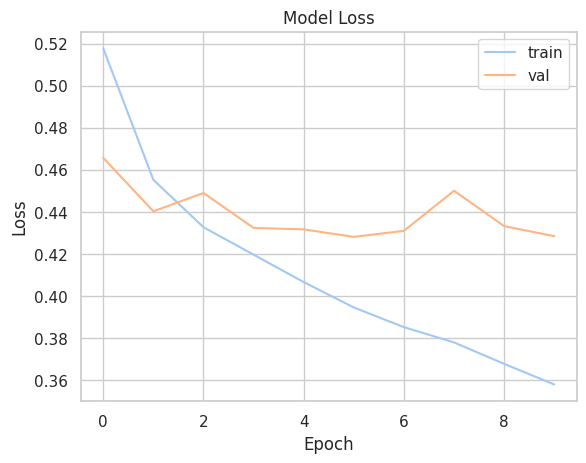

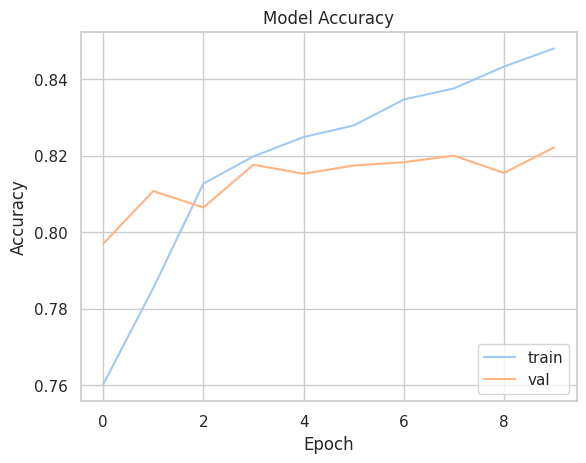

145/145 [==============================] - 1s 5ms/step


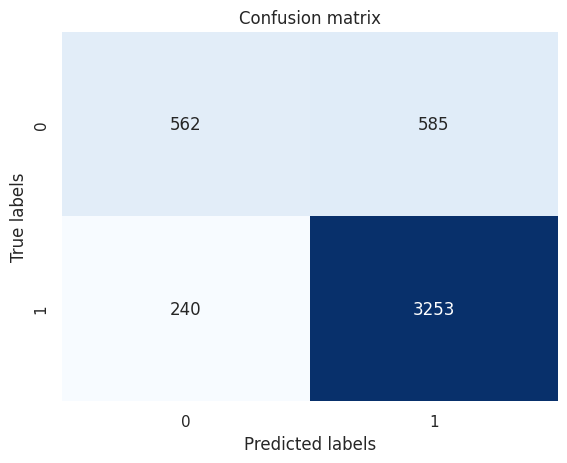

              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1147
           1       0.85      0.93      0.89      3493

    accuracy                           0.82      4640
   macro avg       0.77      0.71      0.73      4640
weighted avg       0.81      0.82      0.81      4640



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
1160/1160 [==============================] - 22s 19ms/step - loss: 0.5735 - accuracy: 0.7780 - val_loss: 0.4805 - val_accuracy: 0.7922
Epoch 2/10
1160/1160 [==============================] - 19s 16ms/step - loss: 0.4596 - accuracy: 0.8010 - val_loss: 0.4928 - val_accuracy: 0.7821
Epoch 3/10
1160/1160 [==============================] - 16s 14ms/step - loss: 0.4424 - accuracy: 0.8093 - val_loss: 0.4504 - val_accuracy: 0.8071
Epoch 4/10
1160/1160 [==============================] - 15s 13ms/step - loss: 0.4238 - accuracy: 0.8171 - val_loss: 0.4502 - val_accuracy: 0.8086
Epoch 5/10
1160/1160 [==============================] - 17s 15ms/step - loss: 0.4142 - accuracy: 0.8231 - val_loss: 0.4459 - val_accuracy: 0.8144
Epoch 6/10
1160/1160 [==============================] - 16s 14ms/step - loss: 0.4051 - accuracy: 0.8250 - val_loss: 0.4292 - val_accuracy: 0.8168
Epoch 7/10
1160/1160 [==============================] - 15s 13ms/step - loss: 0.3969 - accuracy: 0.8314 - val_loss: 0.4417 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

145/145 - 2s - loss: 0.4492 - accuracy: 0.8211 - 2s/epoch - 12ms/step
145/145 [==============================] - 1s 4ms/step
Test Accuracy: 0.8211206793785095
Test F1 Score: 0.8872588970388481
Test Recall: 0.9350128829086745
Precision: 0.8441457741018351


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_1 (LSTM)               (None, 185, 64)          

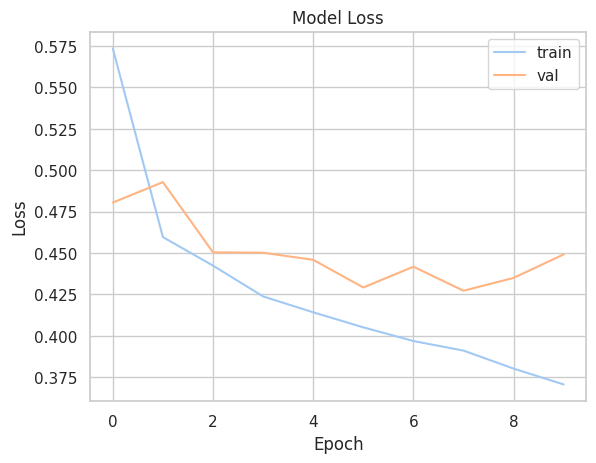

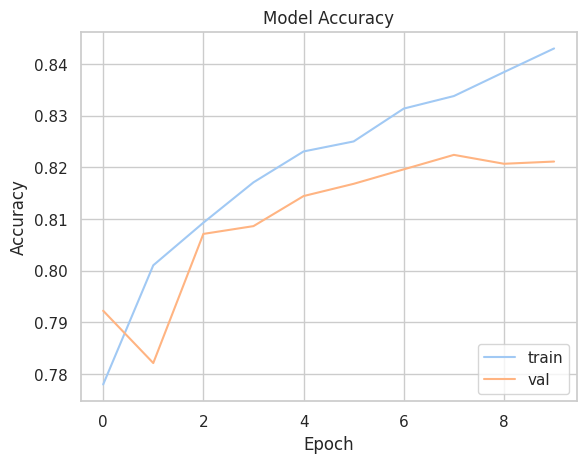

145/145 [==============================] - 1s 4ms/step


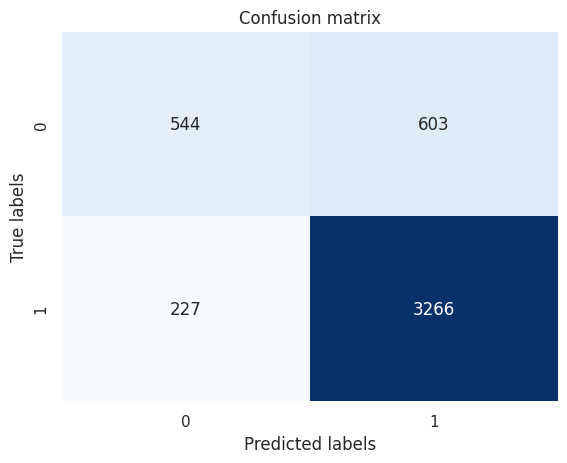

              precision    recall  f1-score   support

           0       0.71      0.47      0.57      1147
           1       0.84      0.94      0.89      3493

    accuracy                           0.82      4640
   macro avg       0.77      0.70      0.73      4640
weighted avg       0.81      0.82      0.81      4640



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
1160/1160 [==============================] - 54s 12ms/step - loss: 0.5151 - accuracy: 0.7657 - val_loss: 0.4943 - val_accuracy: 0.7741
Epoch 2/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4655 - accuracy: 0.7945 - val_loss: 0.4732 - val_accuracy: 0.7871
Epoch 3/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4532 - accuracy: 0.7987 - val_loss: 0.4562 - val_accuracy: 0.7976
Epoch 4/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4465 - accuracy: 0.8016 - val_loss: 0.4499 - val_accuracy: 0.7985
Epoch 5/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4388 - accuracy: 0.8073 - val_loss: 0.4437 - val_accuracy: 0.8052
Epoch 6/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4341 - accuracy: 0.8101 - val_loss: 0.4451 - val_accuracy: 0.8034
Epoch 7/10
1160/1160 [==============================] - 13s 11ms/step - loss: 0.4326 - accuracy: 0.8085 - val_loss: 0.4431 -

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

145/145 - 1s - loss: 0.4377 - accuracy: 0.8099 - 998ms/epoch - 7ms/step
145/145 [==============================] - 1s 5ms/step
Test Accuracy: 0.8099138140678406
Test F1 Score: 0.8815153143471252
Test Recall: 0.9393071858001718
Precision: 0.8304226778030879


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 768, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_17 (Conv1D)             (None, 768, 128)     640         ['input_2[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 768, 128)     768         ['input_2[0][0]']                
                                                                                            

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

145/145 [==============================] - 1s 5ms/step
[[ 477  670]
 [ 212 3281]]
